# Sentiments Analysis

## 1. Introduction



## 2. Getting Started

In [1]:
# Mounting Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')
!pip install bs4

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Setting the path
import os
os.chdir("C:/Users/datal/Desktop/New")

In [5]:
# Importing the dataset
Train = pd.read_csv("./Input/train_F3WbcTw.csv")
Test = pd.read_csv("./Input/test_tOlRoBf.csv")
Sample_submission = pd.read_csv("./Input/sample_submission_i5xnIZD.csv")

## 2. Understanding the data

In [6]:
# Shape of data
print("Number of rows and columns in train dataset:",Train.shape)
print("Number of rows and columns in test dataset:",Test.shape)

Number of rows and columns in train dataset: (5279, 4)
Number of rows and columns in test dataset: (2924, 3)


In [7]:
# Variable structure
print("-----------------Variable Structure of training data--------------")
Train.info()
print("-----------------Variable Structure of test data------------------")
Test.info()

-----------------Variable Structure of training data--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 4 columns):
unique_hash    5279 non-null object
text           5279 non-null object
drug           5279 non-null object
sentiment      5279 non-null int64
dtypes: int64(1), object(3)
memory usage: 165.0+ KB
-----------------Variable Structure of test data------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 3 columns):
unique_hash    2924 non-null object
text           2924 non-null object
drug           2924 non-null object
dtypes: object(3)
memory usage: 68.6+ KB


 
> No missing value has been observed in this data.

Let's reconfirm missing value in another step as well.

In [8]:
print("Missing value in Train data:", Train.isnull().sum().sum())
print("Missing value in Test data:", Test.isnull().sum().sum())

Missing value in Train data: 0
Missing value in Test data: 0


> It got confirmed that this dataset does not contain any missing value.

Let's look at top 5 rowsof train dataset:

In [9]:
# Top 5 rows
Train.head(5)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


Now, let's look at distribution of label:

In [10]:
# Checking distribution of Product_Category
print("The unique number of Product Categories: ",len(Train['sentiment'].unique()))
print("Below are the distribution of each categories in Train data:")
Train['sentiment'].value_counts(normalize = True)

The unique number of Product Categories:  3
Below are the distribution of each categories in Train data:


2    0.724569
1    0.158553
0    0.116878
Name: sentiment, dtype: float64

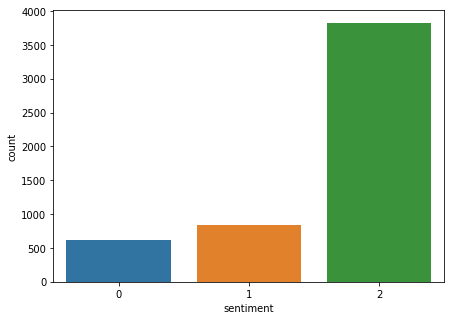

In [11]:
plt.figure(figsize=(7,5))
sns.countplot(x = 'sentiment', data = Train);

> It is clearly visible from above analysis that we are dealing with **unbalanced classification** problem.

In [12]:
Train['pre_clean_len'] = [len(t) for t in Train.text]
Train.head(5)

,unique_hash,text,drug,sentiment,pre_clean_len
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,404
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2,1184
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2,780
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2,124
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1,612


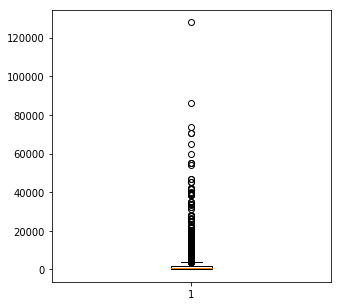

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(Train.pre_clean_len)
plt.show()

## 3. Data Preprocessing

Let's preprocess our data for building classification model. As we already discussed above that our main variable of interest is **text**. On this variable, we are going to apply various NLP techniques.

### 3.1 Defining data cleaning function

In [14]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [15]:
def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

### 3.2 Applying data cleaning function

In [16]:
testing = Train.text[:5]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner_updated(t))
test_result

['autoimmune diseases tend to come in clusters as for gilenya if you feel good don think about it it won change anything but waste your time and energy taking tysabri and feel amazing no symptoms other than dodgy color vision but ve had it since always so don know and don know if it will last month year decade ive just decided to enjoy the ride no point in worrying',
 'can completely understand why you want to try it but results reported in lectures don always stand up to the scrutiny of peer review during publication there so much still to do before this is convincing hope that it does work out really do and if you re aware of and happy with the risks then that great just think it important to present this in balanced way and to understand why we don move straight from the first show of promise in an animal study to using drugs on humans there still lot of animal data to gather and human data to gather before anyone can tell if it safe or effective can tell you how many times animal s

In [17]:
text = Train.text
clean_tweet_texts = []
for t in text:
    clean_tweet_texts.append(tweet_cleaner_updated(t))

Train['clean_tweet_texts'] = clean_tweet_texts
Train.head(5)

,unique_hash,text,drug,sentiment,pre_clean_len,clean_tweet_texts
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,404,autoimmune diseases tend to come in clusters a...
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2,1184,can completely understand why you want to try ...
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2,780,interesting that it only targets receptors rat...
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2,124,very interesting grand merci now wonder where ...
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1,612,hi everybody my latest mri results for brain a...


In [18]:
text_test = Test.text
clean_tweet_texts_test = []
for t in text_test:
    clean_tweet_texts_test.append(tweet_cleaner_updated(t))

Test['clean_tweet_texts'] = clean_tweet_texts_test
Test.head(5)

,unique_hash,text,drug,clean_tweet_texts
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod,previously stable on natalizumab with switchin...
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod,on fingolimod and have been since december the...
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira,apparently it shingles do have few red spots j...
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso,if the docetaxel doing once week weeks then we...
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara,cc stelara worked in matter of days for me if ...


## 4. EDA

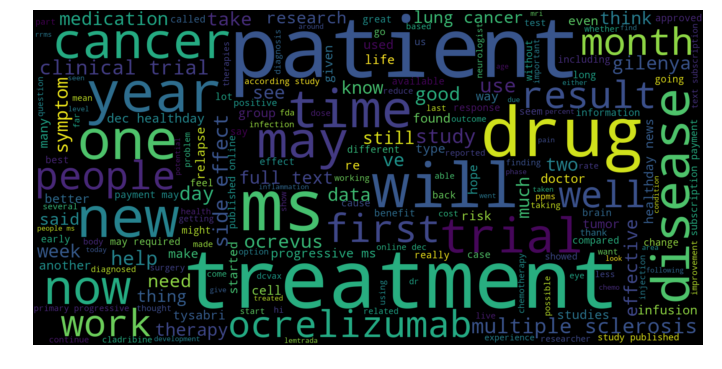

In [19]:
sentiment_0 = Train[Train.sentiment == 0]
string = []
for t in sentiment_0.clean_tweet_texts:
    string.append(t)
string = pd.Series(string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

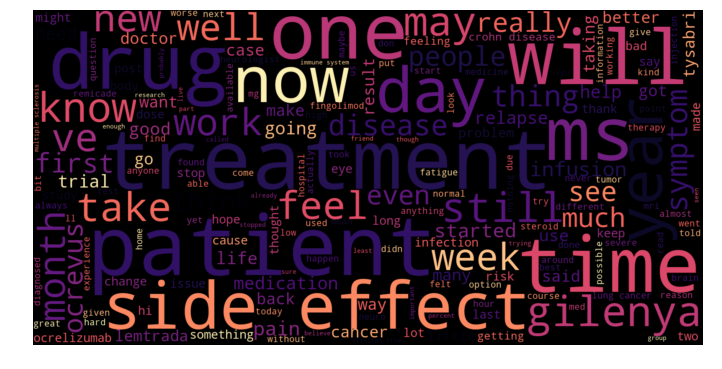

In [20]:
sentiment_1 = Train[Train.sentiment == 1]
string = []
for t in sentiment_1.clean_tweet_texts:
    string.append(t)
string = pd.Series(string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

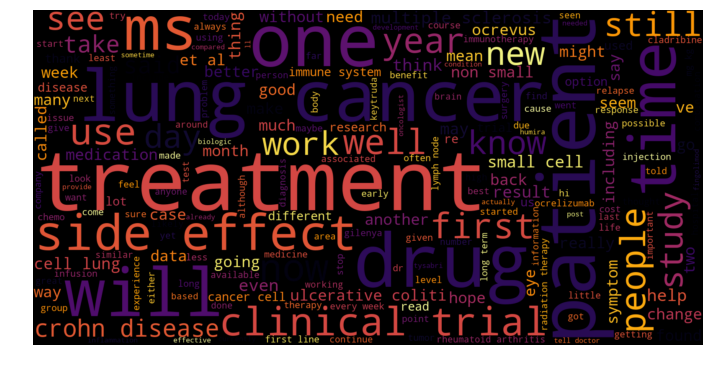

In [21]:
sentiment_2 = Train[Train.sentiment == 2]
string = []
for t in sentiment_2.clean_tweet_texts:
    string.append(t)
string = pd.Series(string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='inferno').generate(string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(Train.clean_tweet_texts)
print("No of tokens in corpus with stopwords:",len(cvec.get_feature_names()))

No of tokens in corpus with stopwords: 36254


In [23]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(Train.clean_tweet_texts)
print("No of tokens in corpus without stopwords:",len(cvec.get_feature_names()))

No of tokens in corpus without stopwords: 35950


## 5. Building a Classifier

After cleanup, it is time to build the classifier to identify Product Categories. At first, we are dividing our data into train and test set.

### 5.1 Train and test split

In [24]:
# Creating the Bag of Words model
X = Train.clean_tweet_texts
y = Train.sentiment

from sklearn.model_selection import train_test_split
SEED = 2000

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size= 0.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size= 0.5, random_state=SEED)


In [25]:

train_size = len(x_train)
train_zero = len(x_train[y_train == 0]) / (len(x_train)*1.)*100
train_one = len(x_train[y_train == 1]) / (len(x_train)*1.)*100
train_two = len(x_train[y_train == 2]) / (len(x_train)*1.)*100

validation_size = len(x_validation)
validation_zero = len(x_validation[y_validation == 0]) / (len(x_validation)*1.)*100
validation_one = len(x_validation[y_validation == 1]) / (len(x_validation)*1.)*100
validation_two = len(x_validation[y_validation == 2]) / (len(x_validation)*1.)*100

test_size = len(x_test)
test_zero = len(x_test[y_test == 0]) / (len(x_test)*1.)*100
test_one = len(x_test[y_test == 1]) / (len(x_test)*1.)*100
test_two = len(x_test[y_test == 2]) / (len(x_test)*1.)*100

train_stats = (train_size, train_zero, train_one, train_two)
validation_stats = (validation_size, validation_zero, validation_one, validation_two)
test_stats = (test_size, test_zero, test_one, test_two)

data_types = ('train', 'validation', 'test')
validation_summary_stats = pd.DataFrame([train_stats, validation_stats, test_stats])
validation_summary_stats.columns = ['samplesize', 'Zero', 'One', 'Two']
validation_summary_stats.index = data_types
validation_summary_stats

,samplesize,Zero,One,Two
train,4223,12.053043,15.960218,71.986739
validation,528,10.227273,16.287879,73.484848
test,528,10.227273,14.583333,75.189394


### 5.2 Checking various Machine Learning models

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import f1_score, classification_report

In [27]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = f1_score(y_test, y_pred, average = "macro")
    return accuracy, train_test_time

In [28]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

names = ["Logistic Regression", "SGDClassifier", "Linear SVC", "LinearSVC with L1-based feature selection","Gaussian SVM",
         "Multinomial NB", "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Randomforest", "GradientBoosting",
         "ExtremeGradientBoosting","Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    SVC(kernel='rbf'), 
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]

zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words="english", ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

classifier_result = classifier_comparator(n_features=2000,ngram_range=(1,3))
classifier_result

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Validation result for SGDClassifier
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Validatio

[('Logistic Regression', 0.3665295735274956, 8.86069369316101),
 ('SGDClassifier', 0.479351065981203, 9.054069519042969),
 ('Linear SVC', 0.5094448621385818, 9.079715490341187),
 ('LinearSVC with L1-based feature selection',
  0.4940975803443723,
  10.656500577926636),
 ('Gaussian SVM', 0.2823871906841339, 20.121909141540527),
 ('Multinomial NB', 0.3544872986118701, 9.325398921966553),
 ('Bernoulli NB', 0.32808049375473386, 9.121614456176758),
 ('Ridge Classifier', 0.46002337943051225, 9.402979373931885),
 ('AdaBoost', 0.3890288441989402, 11.862752914428711),
 ('Randomforest', 0.3474796412095719, 9.719185590744019),
 ('GradientBoosting', 0.32589274604952095, 44.73086714744568),
 ('ExtremeGradientBoosting', 0.33487522128947517, 30.897139310836792),
 ('Perceptron', 0.46745267944685365, 9.027895450592041),
 ('Passive-Aggresive', 0.4931721035279411, 9.018114566802979),
 ('Nearest Centroid', 0.43124952435990965, 9.080682039260864)]

In [29]:
classifier_result_df = pd.DataFrame(classifier_result)
classifier_result_df.columns = ['Classifier', 'F1-Score', 'Train and test time']
classifier_result_df.sort_values(by='F1-Score', ascending=False)

,Classifier,F1-Score,Train and test time
2,Linear SVC,0.509445,9.079715
3,LinearSVC with L1-based feature selection,0.494098,10.656501
13,Passive-Aggresive,0.493172,9.018115
1,SGDClassifier,0.479351,9.054070
12,Perceptron,0.467453,9.027895
7,Ridge Classifier,0.460023,9.402979
14,Nearest Centroid,0.431250,9.080682
8,AdaBoost,0.389029,11.862753
0,Logistic Regression,0.366530,8.860694
5,Multinomial NB,0.354487,9.325399


### 5.3 Ensemble learning

In [30]:
from sklearn.ensemble import VotingClassifier

clf1 = LinearSVC()
clf2 = PassiveAggressiveClassifier()
clf3 = Perceptron()
clf4 = RidgeClassifier()
clf5 = SGDClassifier()

eclf = VotingClassifier(estimators=[('svc', clf1), ('pac', clf2), ('perc', clf3), ('rcs', clf4), ('sgd', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Linear SVC', 'Passive-Aggresive', 'Perceptron', 'Ridge Classifier', 'SGDClassifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=2000,ngram_range=(1, 3), stop_words="english")),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    print(clf_accuracy)

Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.5094448621385818
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)
0.5206368171885413
Validation result for Perceptron
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)
0.46745267944685365

### 5.4 Final Model

In [31]:
pipeline_LinearSVC = Pipeline([
    ('vect', TfidfVectorizer(max_features=2000,ngram_range=(1,3), stop_words="english")),
    ('SVM', LinearSVC()),
])

model_SVM = pipeline_LinearSVC.fit(x_train, y_train)

# Scoring based on F1 score
y_predict_SVM = model_SVM.predict(x_validation)
scores_holdout = f1_score(y_validation, y_predict_SVM, average="macro")
print(classification_report(y_validation, y_predict_SVM))
print("F1 Score for hold-out sample data:", round(scores_holdout*100,2))

              precision    recall  f1-score   support

           0       0.38      0.24      0.30        54
           1       0.51      0.31      0.39        86
           2       0.79      0.90      0.84       388

   micro avg       0.74      0.74      0.74       528
   macro avg       0.56      0.49      0.51       528
weighted avg       0.71      0.74      0.71       528

F1 Score for hold-out sample data: 50.94


In [32]:
# Scoring based on F1 score
from sklearn.metrics import accuracy_score
y_predict_SVM = model_SVM.predict(x_test)
scores_holdout = f1_score(y_test, y_predict_SVM, average="macro")
scores = accuracy_score(y_test, y_predict_SVM)
print(classification_report(y_test, y_predict_SVM))
print("F1 Score for hold-out sample data:", round(scores_holdout*100,2))
print("Accuracy Score for hold-out sample data:", round(scores*100,2))

              precision    recall  f1-score   support

           0       0.26      0.11      0.16        54
           1       0.43      0.34      0.38        77
           2       0.79      0.89      0.84       397

   micro avg       0.73      0.73      0.73       528
   macro avg       0.49      0.45      0.46       528
weighted avg       0.68      0.73      0.70       528

F1 Score for hold-out sample data: 45.66
Accuracy Score for hold-out sample data: 72.73


In [33]:
# Scoring based on F1 score for cross validation
from sklearn.model_selection import StratifiedKFold, cross_val_score
seed = 123
skf = StratifiedKFold(n_splits=10, random_state=seed)
scores_cv = cross_val_score(model_SVM, x_train, y_train, cv=skf, scoring='f1_macro')
print("F1 Score based on cross validation:" , round(scores_cv.mean()*100,2))

F1 Score based on cross validation: 42.04


## 6. Predicting test data

In [35]:
Test['y_predict_SVM'] = model_SVM.predict(Test.clean_tweet_texts)
Submission = Test[['unique_hash','y_predict_SVM']]
Submission = Submission.rename(columns = {'y_predict_SVM':'sentiment'})
Submission.head(5)

# Exporting output
Submission.to_csv("./Output/Output_v2.csv", index = False)